<h3>Report</h3>

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
import seaborn as sns

<h3>Loading Models</h3>

In [3]:
from core.network import *
from core.trainer import *
from core.visualization import *

In [4]:
device = torch.device("cuda:0")
dir_load = '../models/'

In [5]:
net = LSTM(1, 98, 9, num_layers=3, device=device).to(device)
model = LSTMTrainer(net, device=device)
model2 = LSTMTrainer(net, device=device)

<h3>Dataloading for Eval</h3>

In [6]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288

In [7]:
from core.getdata import *
from core.dataset import * 
from core.dataset2 import *

In [8]:
data = DatasetPolar(ligands, polarization, replicas, size)
data2 = DatasetNaive(ligands, replicas, size)

In [9]:
from torch.utils.data import Dataset
from torchvision import datasets

In [10]:
print(len(data), 0.25 * len(data)) # we'll test our data on 25% of the dataset
print(len(data2), 0.25 * len(data2))

69552 17388.0
11592 2898.0


In [11]:
_, datatest = torch.utils.data.random_split(data, [69552 - 17388 - 24, 17388 + 24])
_, dataset2 = torch.utils.data.random_split(data2, [11592 - 2880, 2880]) # 302
testloader = torch.utils.data.DataLoader(datatest, batch_size=32, shuffle=True)
testloader2 = torch.utils.data.DataLoader(dataset2, batch_size=16, shuffle=True)

<h3>Evaluation Loop</h3>

In [12]:
model.load(dir_load + 'lstm1.pth') # polarized

In [13]:
polarization_true, polarization_pred, polarized_prob = np.empty([32,]).T, np.empty([32,]).T, np.empty([32,9])

In [14]:
for x, y in testloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    polarization_true = np.hstack([polarization_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    # y_prob = np.amax(y_pred, axis=1)
    # import pdb; pdb.set_trace()
    polarized_prob = np.vstack([polarized_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    polarization_pred = np.hstack([polarization_pred, y_pred.T])
    #y_true = (32, ); y_pred = (32, ); y_prob = (32, 9)

In [15]:
model2.load(dir_load + 'lstm.pth') # naive

In [16]:
naive_true, naive_pred, naive_prob = np.empty([16,]).T, np.empty([16,]).T, np.empty([16,9])

In [17]:
for x2, y2 in testloader2:
    x2, y2 = x2.to(device), y2.to(device)
    y_true = y2.detach().cpu().numpy()
    naive_true = np.hstack([naive_true, y_true.T])
    y_pred = model2.network(x2)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    # y_prob = np.amax(y_pred, axis=1)
    naive_prob = np.vstack([naive_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    #import pdb; pdb.set_trace()
    naive_pred = np.hstack([naive_pred, y_pred.T])
    #y_true = (16, ); y_pred = (16, ); y_prob = (16, 9)

In [18]:
polarization_true, polarization_pred, polarized_prob = polarization_true[32:], polarization_pred[32:], polarized_prob[32:]
naive_true, naive_pred, naive_prob = naive_true[16:], naive_pred[16:], naive_prob[16:]
print(naive_true.shape, naive_pred.shape, polarization_true.shape, polarization_pred.shape, polarized_prob.shape, naive_prob.shape)

(2880,) (2880,) (17412,) (17412,) (17412, 9) (2880, 9)


In [19]:
comparison = np.vstack([polarization_true, polarization_pred]).T
comparison2 = np.vstack([naive_true, naive_pred]).T

In [20]:
df, df2 = pd.DataFrame(comparison), pd.DataFrame(comparison2)

In [21]:
print(df)

         0    1
0      0.0  0.0
1      4.0  4.0
2      8.0  8.0
3      1.0  0.0
4      8.0  8.0
...    ...  ...
17407  4.0  4.0
17408  8.0  8.0
17409  7.0  7.0
17410  2.0  2.0
17411  7.0  7.0

[17412 rows x 2 columns]


In [22]:
print(df2)

        0    1
0     7.0  7.0
1     6.0  6.0
2     2.0  2.0
3     2.0  2.0
4     0.0  0.0
...   ...  ...
2875  1.0  0.0
2876  6.0  6.0
2877  3.0  3.0
2878  2.0  2.0
2879  4.0  4.0

[2880 rows x 2 columns]


<h3>Naive/Polarized Metrics</h3>

In [23]:
# ACCURACY
print(f' Naive Accuracy: {sum(df2[0] == df2[1])/2880} \n Polarized Accuracy: {sum(df[0] == df[1])/17412}')

 Naive Accuracy: 0.9600694444444444 
 Polarized Accuracy: 0.9139099471628762


In [24]:
naive_report = sklearn.metrics.classification_report(df2[0], df2[1], target_names=ligands, output_dict=True)
naive_rep = pd.DataFrame(naive_report).transpose()

polarized_report = sklearn.metrics.classification_report(df[0], df[1], target_names=ligands, output_dict=True)
polarized_rep = pd.DataFrame(polarized_report).transpose()

In [25]:
print(naive_rep)

              precision    recall  f1-score      support
TNF            0.951429  0.988131  0.969432   337.000000
R84            0.981273  0.842444  0.906574   311.000000
PIC            0.984663  0.990741  0.987692   324.000000
P3K            0.939210  0.984076  0.961120   314.000000
FLA            0.966667  0.955090  0.960843   334.000000
CpG            0.974277  0.952830  0.963434   318.000000
FSL            0.931677  0.943396  0.937500   318.000000
LPS            0.937870  0.984472  0.960606   322.000000
UST            0.980456  0.996689  0.988506   302.000000
accuracy       0.960069  0.960069  0.960069     0.960069
macro avg      0.960836  0.959763  0.959523  2880.000000
weighted avg   0.960695  0.960069  0.959621  2880.000000


In [26]:
print(polarized_rep)

              precision    recall  f1-score      support
TNF            0.937931  0.885772  0.911105   1996.00000
R84            0.926715  0.923834  0.925272   1930.00000
PIC            0.932933  0.956388  0.944515   1949.00000
P3K            0.903527  0.914916  0.909186   1904.00000
FLA            0.861609  0.887071  0.874155   1895.00000
CpG            0.883394  0.883394  0.883394   1921.00000
FSL            0.882615  0.904569  0.893457   1970.00000
LPS            0.900588  0.870351  0.885211   1936.00000
UST            0.997911  1.000000  0.998955   1911.00000
accuracy       0.913910  0.913910  0.913910      0.91391
macro avg      0.914136  0.914033  0.913917  17412.00000
weighted avg   0.914216  0.913910  0.913893  17412.00000


In [27]:
polarizedf1, naivef1, totalf1 = polarized_rep[:9], naive_rep[:9], pd.concat([polarized_rep[:9], naive_rep[:9]], axis=1)

<h4>F1 Polarized Ligands</h4>

<AxesSubplot:>

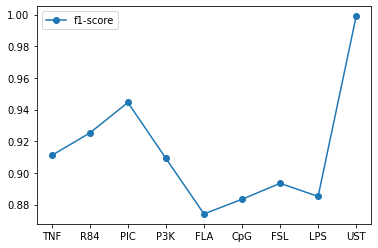

In [28]:
polarizedf1.plot(y='f1-score', style='o-')

<h4>F1 Naive Ligands</h4>

<AxesSubplot:>

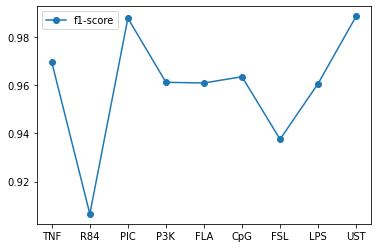

In [29]:
naivef1.plot(y='f1-score', style='o-')

<h4>F1 Ligands</h4>

<AxesSubplot:>

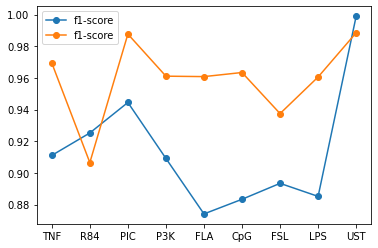

In [30]:
totalf1.plot(y='f1-score', style='o-') # orange: naive | blue: polarized

In [31]:
polarized_confusion = sklearn.metrics.confusion_matrix(df[0], df[1])
pccm = sklearn.metrics.ConfusionMatrixDisplay(polarized_confusion)

naive_confusion = sklearn.metrics.confusion_matrix(df2[0], df2[1])
nccm = sklearn.metrics.ConfusionMatrixDisplay(naive_confusion)

polarized_fraction = Fraction(polarization_true, polarized_prob)
naive_fraction = Fraction(naive_true, naive_prob)

<h4>Naive Confusion Matrix/Fraction</h4>

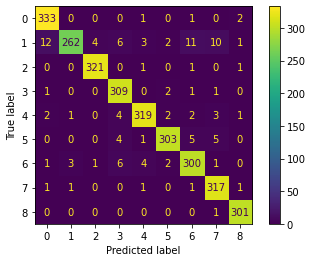

In [32]:
nccm.plot()

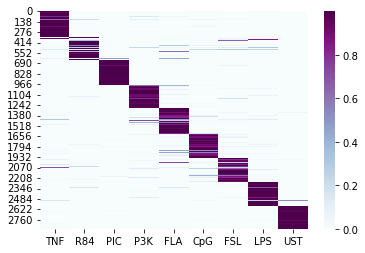

In [33]:
ncf = sns.heatmap(naive_fraction, cmap="BuPu", xticklabels=ligands) # BuPu, mako, magma

<h4>Polarized Confusion Matrix/Fraction</h4>

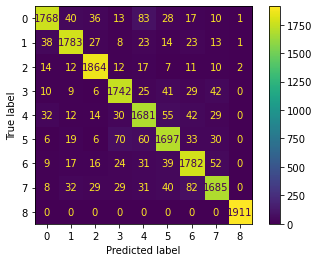

In [34]:
pccm.plot()

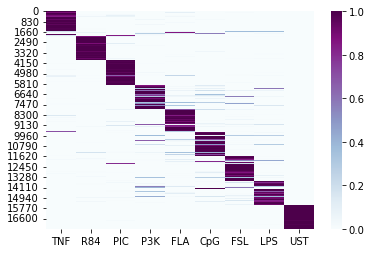

In [35]:
pcf = sns.heatmap(polarized_fraction, cmap="BuPu", xticklabels=ligands) # BuPu, mako, magma

In [36]:
# pcfm.plot()

<h3>Polarization State Analysis</h3>

In [37]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288

In [38]:
unpolarized_data = DatasetPolar(ligands, [""], replicas, size)
ib = DatasetPolar(ligands, ["ib"], replicas, size)
ig = DatasetPolar(ligands, ["ig"], replicas, size)
i0 = DatasetPolar(ligands, ["i0"], replicas, size)
i3 = DatasetPolar(ligands, ["i3"], replicas, size)
i4 = DatasetPolar(ligands, ["i4"], replicas, size)

In [39]:
print(len(unpolarized_data) + len(ib) + len(ig) + len(i0) + len(i3) + len(i4))
print(len(i4))

69552
11592


In [40]:
_, unpolarizedtest = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, ibtest = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, igtest = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, i0test = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, i3test = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, i4test = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])

uploader = torch.utils.data.DataLoader(unpolarizedtest, batch_size=32, shuffle=True)
ibloader = torch.utils.data.DataLoader(ibtest, batch_size=32, shuffle=True)
igloader = torch.utils.data.DataLoader(igtest, batch_size=32, shuffle=True)
i0loader = torch.utils.data.DataLoader(i0test, batch_size=32, shuffle=True)
i3loader = torch.utils.data.DataLoader(i3test, batch_size=32, shuffle=True)
i4loader = torch.utils.data.DataLoader(i4test, batch_size=32, shuffle=True)

<h3>Evaluation Loop</h3>

In [41]:
model.load(dir_load + 'lstm1.pth') # polarized

In [42]:
up_true, up_pred, up_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])
ib_true, ib_pred, ib_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])
ig_true, ig_pred, ig_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])
i0_true, i0_pred, i0_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])
i3_true, i3_pred, i3_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])
i4_true, i4_pred, i4_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])

In [43]:
for x, y in uploader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    up_true = np.hstack([up_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    up_prob = np.vstack([up_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    up_pred = np.hstack([up_pred, y_pred.T])
    
for x, y in ibloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    ib_true = np.hstack([up_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    ib_prob = np.vstack([ib_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    ib_pred = np.hstack([up_pred, y_pred.T])
    
for x, y in igloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    ig_true = np.hstack([ig_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    ig_prob = np.vstack([ig_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    ig_pred = np.hstack([ig_pred, y_pred.T])
    
for x, y in i0loader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    i0_true = np.hstack([i0_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    i0_prob = np.vstack([i0_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    i0_pred = np.hstack([i0_pred, y_pred.T])
    
for x, y in i3loader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    i3_true = np.hstack([i3_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    i3_prob = np.vstack([i3_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    i3_pred = np.hstack([i3_pred, y_pred.T])
    
for x, y in i4loader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    i4_true = np.hstack([i4_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    i4_prob = np.vstack([i4_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    i4_pred = np.hstack([i4_pred, y_pred.T])

In [44]:
up_true, up_pred, up_prob = up_true[32:], up_pred[32:], up_prob[32:]
ib_true, ib_pred, ib_prob = ib_true[64:], ib_pred[64:], ib_prob[32:] #not sure why ib true is 32 indices larger
ig_true, ig_pred, ig_prob = ig_true[32:], ig_pred[32:], ig_prob[32:]
i0_true, i0_pred, i0_prob = i0_true[32:], i0_pred[32:], i0_prob[32:]
i3_true, i3_pred, i3_prob = i3_true[32:], i3_pred[32:], i3_prob[32:]
i4_true, i4_pred, i4_prob = i4_true[32:], i4_pred[32:], i4_prob[32:]

In [45]:
print(ib_true.shape, ib_pred.shape, ib_prob.shape)
print(ig_true.shape, ig_pred.shape, ig_prob.shape)
print(i0_true.shape, i0_pred.shape, i0_prob.shape)
print(i3_true.shape, i3_pred.shape, i3_prob.shape)
print(i4_true.shape, i4_pred.shape, i4_prob.shape)

(3200,) (3200,) (3200, 9)
(3200,) (3200,) (3200, 9)
(3200,) (3200,) (3200, 9)
(3200,) (3200,) (3200, 9)
(3200,) (3200,) (3200, 9)


In [46]:
up_df = np.vstack([up_true, up_pred]).T
up_df = pd.DataFrame(up_df)
up_fraction = Fraction(up_true, up_prob)

ib_df = np.vstack([ib_true, ib_pred]).T
ib_df = pd.DataFrame(ib_df)
ib_fraction = Fraction(ib_true, ib_prob)

ig_df = np.vstack([ig_true, ig_pred]).T
ig_df = pd.DataFrame(ig_df)
ig_fraction = Fraction(ig_true, ig_prob)

i0_df = np.vstack([i0_true, i0_pred]).T
i0_df = pd.DataFrame(i0_df)
i0_fraction = Fraction(i0_true, i0_prob)

i3_df = np.vstack([i3_true, i3_pred]).T
i3_df = pd.DataFrame(i3_df)
i3_fraction = Fraction(i3_true, i3_prob)

i4_df = np.vstack([i4_true, i4_pred]).T
i4_df = pd.DataFrame(i4_df)
i4_fraction = Fraction(i4_true, i4_prob)

<h4>Unpolarized</h4>

        0    1
0     6.0  6.0
1     2.0  2.0
2     0.0  0.0
3     3.0  3.0
4     3.0  1.0
...   ...  ...
3195  6.0  0.0
3196  5.0  5.0
3197  4.0  4.0
3198  2.0  2.0
3199  6.0  6.0

[3200 rows x 2 columns]
 Accuracy: 0.8878125


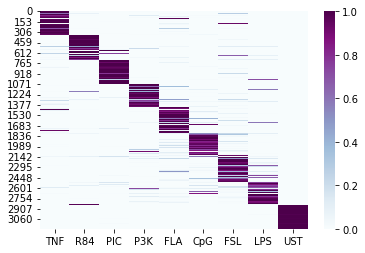

In [47]:
upcf = sns.heatmap(up_fraction, cmap = "BuPu", xticklabels=ligands)
print(up_df)
print(f' Accuracy: {sum(up_df[0] == up_df[1])/3200}')

<h4>ib (NEED TO FIX THIS)</h4>

        0    1
0     8.0  8.0
1     6.0  6.0
2     4.0  4.0
3     8.0  8.0
4     1.0  1.0
...   ...  ...
3195  7.0  7.0
3196  2.0  2.0
3197  4.0  4.0
3198  8.0  8.0
3199  3.0  6.0

[3200 rows x 2 columns]
 Accuracy: 0.8875


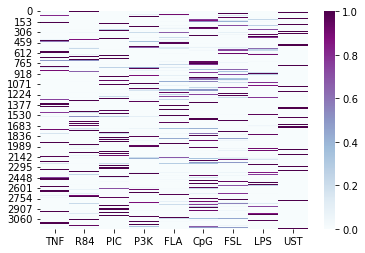

In [53]:
ibcf = sns.heatmap(ib_fraction, cmap = "BuPu", xticklabels=ligands)
print(ib_df)
print(f' Accuracy: {sum(ib_df[0] == ib_df[1])/3200}')

<h4>ig</h4>

        0    1
0     8.0  8.0
1     1.0  1.0
2     0.0  1.0
3     7.0  7.0
4     3.0  3.0
...   ...  ...
3195  8.0  8.0
3196  5.0  6.0
3197  8.0  8.0
3198  6.0  6.0
3199  6.0  6.0

[3200 rows x 2 columns]
 Accuracy: 0.889375


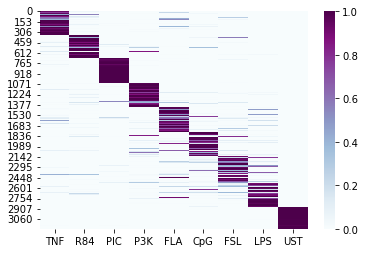

In [54]:
igcf = sns.heatmap(ig_fraction, cmap = "BuPu", xticklabels=ligands)
print(ig_df)
print(f' Accuracy: {sum(ig_df[0] == ig_df[1])/3200}')

<h4>i0</h4>

        0    1
0     6.0  6.0
1     4.0  4.0
2     5.0  5.0
3     8.0  8.0
4     3.0  3.0
...   ...  ...
3195  8.0  8.0
3196  0.0  0.0
3197  5.0  5.0
3198  1.0  1.0
3199  6.0  6.0

[3200 rows x 2 columns]
 Accuracy: 0.88625


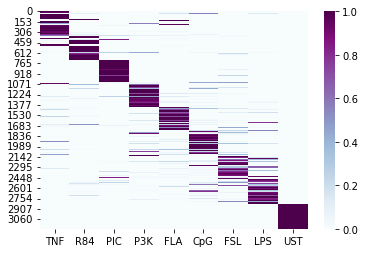

In [50]:
i0cf = sns.heatmap(i0_fraction, cmap = "BuPu", xticklabels=ligands)
print(i0_df)
print(f' Accuracy: {sum(i0_df[0] == i0_df[1])/3200}')

<h4>i3</h4>

        0    1
0     5.0  5.0
1     0.0  0.0
2     2.0  2.0
3     4.0  4.0
4     5.0  5.0
...   ...  ...
3195  6.0  3.0
3196  8.0  8.0
3197  2.0  2.0
3198  1.0  1.0
3199  5.0  5.0

[3200 rows x 2 columns]
 Accuracy: 0.8928125


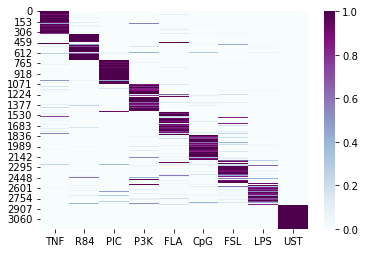

In [51]:
i3cf = sns.heatmap(i3_fraction, cmap = "BuPu", xticklabels=ligands)
print(i3_df)
print(f' Accuracy: {sum(i3_df[0] == i3_df[1])/3200}')

<h4>i4</h4>

        0    1
0     5.0  5.0
1     1.0  5.0
2     0.0  0.0
3     0.0  0.0
4     0.0  0.0
...   ...  ...
3195  1.0  1.0
3196  8.0  8.0
3197  5.0  5.0
3198  1.0  1.0
3199  2.0  2.0

[3200 rows x 2 columns]
 Accuracy: 0.8903125


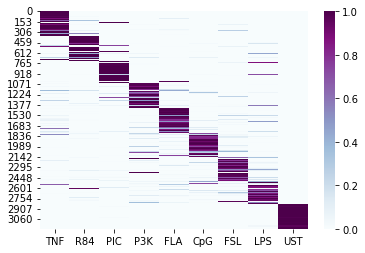

In [52]:
i4cf = sns.heatmap(i4_fraction, cmap = "BuPu", xticklabels=ligands)
print(i4_df)
print(f' Accuracy: {sum(i4_df[0] == i4_df[1])/3200}')